# Multiclass Classification Project
### Learning Goals

* How to read different size images from a directory?
* How to implement One-vs-one scheme for Multiclass classification?
* How to use SVM for image classifcation?

In [1]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


In [2]:
p = Path("images/")
dirs = p.glob("*")

label_dic ={'cat':0,'dog':1,'horse':2,'human':3}
labels=[]
images =[]
for folder_name in dirs:
    print(folder_name)
    label = str(folder_name).split("\\")[-1][:-1]
    
    for i in folder_name.glob("*.jpg"):
        img = image.load_img(i,target_size=(50,50))
        img_array = image.img_to_array(img)
        images.append(img_array)
        labels.append(label_dic[label])

images\cats
images\dogs
images\horses
images\humans


In [3]:
images = np.array(images,dtype=np.float32)/255
labels = np.array(labels)

combined = list(zip(images,labels))
random.shuffle(combined)
images[:],labels[:] = zip(*combined)

In [4]:
def drawImage(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

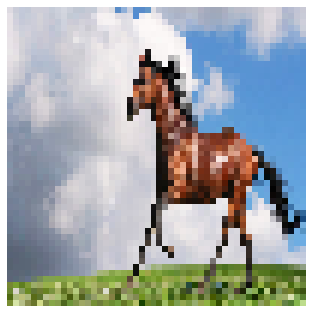

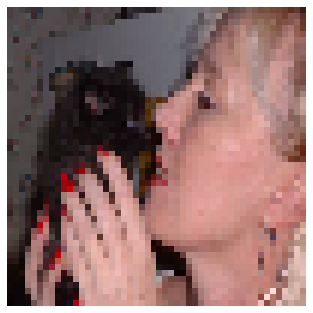

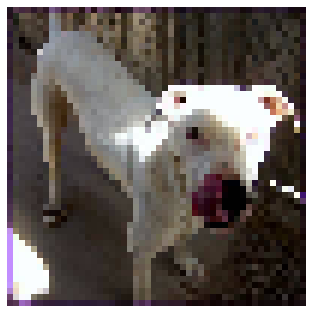

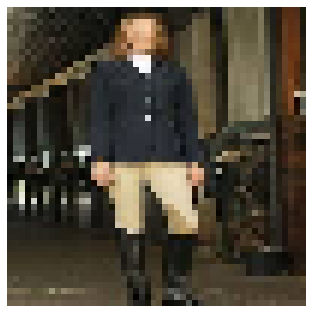

In [5]:
for i in range(4):
    drawImage(images[i])

In [6]:
class SVM:
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0 
        self.b = 0
    def hingeloss(self,W,b,X,y):
        loss = 0.0
        
        loss += 0.5 * np.dot(W,W.T)
        m = X.shape[0]
        for i in range(m):
            ti = y[i] * (np.dot(W,X[i].T) + b)
            
            loss += self.C * max(0,1-ti)
        return loss[0][0]
    def fit(self,X,y,batch_size=100,lr=0.001,maxIter=300):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        c = self.C
        W = np.zeros((1,no_of_features))
        b = 0.0
        loss_list = [] 
        
        for i in range(maxIter):
            loss = self.hingeloss(W,b,X,y)
            loss_list.append(loss)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            for j in range(0,no_of_samples,batch_size):
                grad_w,grad_b = 0, 0
                
                for z in range(j,j+batch_size):
                    if z<no_of_samples:
                        id_ = ids[z]
                        ti = y[id_] * (np.dot(W,X[id_].T) + b)
                        
                        if ti<1:
                            grad_w += c*(X[id_]*y[id_])
                            grad_b += c*(y[id_])
                W = W - lr * W + lr* grad_w
                b = b + lr * grad_b
        self.W = W[0]
        self.b = b
        return W[0],b,loss_list

In [7]:
images = images.reshape((images.shape[0],-1))

In [8]:
def classWiseData(X,y):
    data = {}
    for i in range(len(label_dic.values())):
        data[i]=[]
    for i in range(X.shape[0]):
        data[y[i]].append(X[i])
    
    for k in data.keys():
        data[k] = np.array(data[k])
    return data

In [9]:
data = classWiseData(images,labels)

In [10]:
def getDataPair(d1,d2):
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    label_pair = np.zeros((samples,))
    
    data_pair[:l1,:]=d1
    data_pair[l1:,:]=d2
    
    label_pair[:l1]=-1
    label_pair[l1:]=+1
    
    return data_pair,label_pair

In [11]:
model = SVM()

In [12]:
dic_list=["cat","Dog","Horse","Human"]
def trainSVM():
    svm_classifier={}
    for i in range(len(label_dic.values())):
        svm_classifier[i]={}
        for j in range(i+1,len(label_dic.values())):
            X_pair,y_pair=getDataPair(data[i],data[j])
            W,b,loss_list = model.fit(X_pair,y_pair,lr=0.00001,maxIter=1000)
            svm_classifier[i][j]=(W,b)
            plt.plot(loss_list)
            plt.title(dic_list[i]+" - "+dic_list[j]+" Loss")
            plt.show()
    return svm_classifier

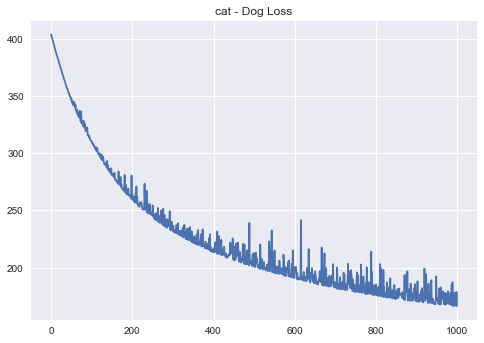

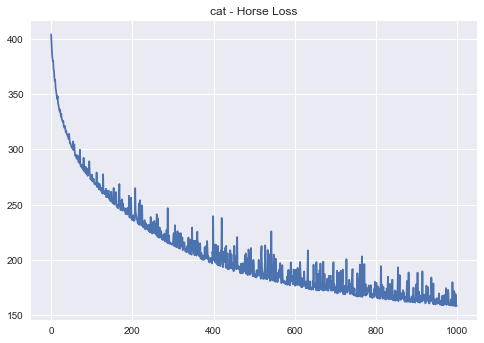

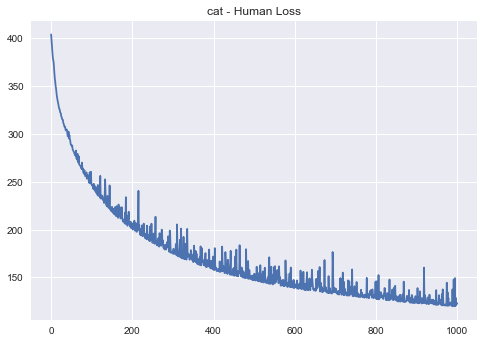

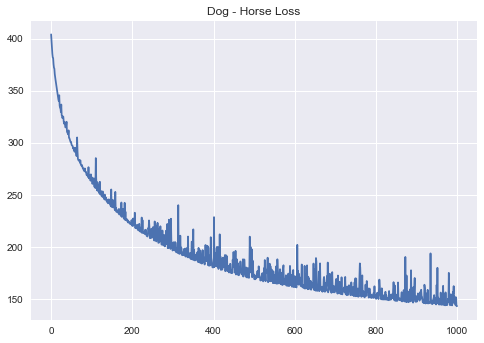

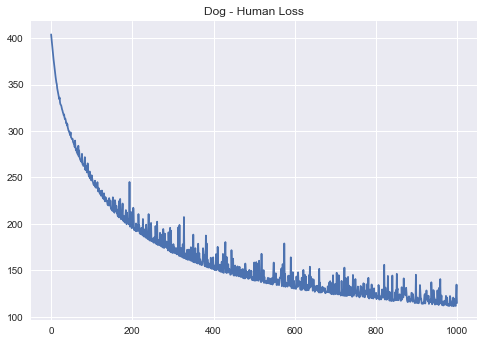

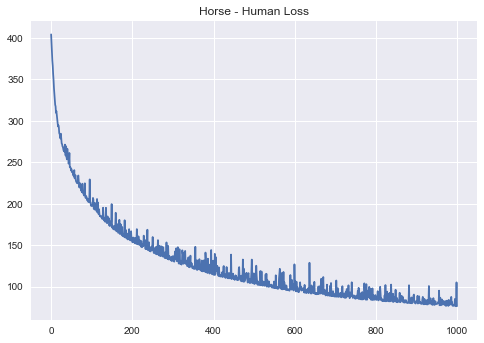

In [13]:
svm_classifier = trainSVM()

In [14]:
cat_dog = svm_classifier[0][1]
print(cat_dog[0].shape)
print(cat_dog[1])

(7500,)
-0.009430000000000008


In [15]:
def binaryPredict(X,W,b):
    z = np.dot(X,W.T)+b
    
    if z>=0:
        return 1
    else:
        return -1
    
def predict(X):
    count = np.zeros((len(label_dic.values()),))
    for i in range(len(label_dic.values())):
        for j in range(i+1,len(label_dic.values())):
            W,b = svm_classifier[i][j]
            z=binaryPredict(X,W,b)
            
            if z==1:
                count[j]+=1
            else:
                count[i]+=1
    return np.argmax(count)
def accuracy(X,y):
    count =0 
    for i in range(X.shape[0]):
        prediction = predict(X[i])
        if prediction==y[i]:
            count+=1
    return count/X.shape[0]

In [16]:
print(accuracy(images,labels)*100)

63.98514851485149


In [17]:
from sklearn.svm import SVC

In [ ]:
svm_classifier = SVC(kernel='linear',C=1.0)
svm_classifier.fit(images,labels)
print(svm_classifier.score(images,labels)*100)